<a href="https://colab.research.google.com/github/GuilhermeDS-ML/Store_Marketing_Campaign/blob/main/Store_Marketing_Campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Disclaimer:**

- The exact year of the dataset was not found, so we will consider the year of the last available record (2014).

- The dataset does not mention whether the 'Purchases' variables overlap. In a real scenario, it would be necessary to confirm this information with the data collection team. However, in this case, we will assume there is no overlap. That is, if a purchase is recorded in 'NumWebPurchases', it is not recorded in 'NumCatalogPurchases', and vice versa.

Dataset link: https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset/data

# Import and Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings('ignore')

In [2]:
def nulls(df):
    length = df.shape[0]
    cols_null = df.columns[df.isnull().sum() > 0]
    return df.loc[:, cols_null].isnull().sum().to_frame('values_missing').assign(rate=lambda x: (x / length) * 100).round(2).reset_index().rename(columns={'index': 'cols'})

In [3]:
df = pd.read_csv('/content/superstore_data.csv')

# Data description

| Variable Name | Description |
|---|---|
| Response | 1 if the customer accepted the offer in the last campaign, 0 otherwise |
| ID | Unique ID of each customer |
| Year_Birth | Age of the customer |
| Complain | 1 if the customer complained in the last 2 years, 0 otherwise |
| Dt_Customer | Date of customer's enrollment with the company |
| Education | Customer's level of education |
| Marital | Customer's marital status |
| Kidhome | Number of small children in customer's household |
| Teenhome | Number of teenagers in customer's household |
| Income | Customer's yearly household income |
| MntFishProducts | Amount spent on fish products in the last 2 years |
| MntMeatProducts | Amount spent on meat products in the last 2 years |
| MntFruits | Amount spent on fruits products in the last 2 years |
| MntSweetProducts | Amount spent on sweet products in the last 2 years |
| MntWines | Amount spent on wine products in the last 2 years |
| MntGoldProds | Amount spent on gold products in the last 2 years |
| NumDealsPurchases | Number of purchases made with discount |
| NumCatalogPurchases | Number of purchases made using catalog (buying goods to be shipped through the mail) |
| NumStorePurchases | Number of purchases made directly in stores |
| NumWebPurchases | Number of purchases made through the company's website |
| NumWebVisitsMonth | Number of visits to company's website in the last month |
| Recency | Number of days since the last purchase |

# EDA

## Overview

In [4]:
df.shape

(2240, 22)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
nulls(df)

,cols,values_missing,rate
0,Income,24,1.07


In [7]:
df.dropna(inplace=True)

In [8]:
df.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,6/16/2014,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,6/15/2014,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,5/13/2014,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,11/5/2014,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,8/4/2014,0,6,...,11,0,34,2,3,1,2,7,1,0


In [9]:
df.Id.nunique()

2216

## Initial Data Processing

In [10]:
# For convenience, let's put the column names in lowercase
df.columns = df.columns.str.lower()

In [11]:
df['id'].nunique(), df.shape[0]

(2216, 2216)

In [12]:
# The 'id' in this case does not repeat, making it a redundant variable for our analysis
df.drop('id', axis=1, inplace=True)

In [13]:
# Separing data types
objs = df.select_dtypes('object').columns.tolist()
cats = [x for x in df.columns if x not in objs and df[x].nunique() < 20]
nums = [x for x in df.columns if x not in objs and x not in cats]

In [14]:
objs

['education', 'marital_status', 'dt_customer']

In [15]:
df['dt_customer'].sample(5)

,dt_customer
1660,10/14/2012
1116,10/21/2012
1372,12/24/2012
1615,8/21/2012
1387,11/5/2013


This is a date type variable, but it's currently an object. Let's fix it

In [16]:
df['dt_customer'] = pd.to_datetime(df['dt_customer'])

In [17]:
# Let's calculate the customer's age
year = 2014
df['age'] = year - df['year_birth']

In [18]:
df.head()

,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,...,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,response,complain,age
0,1970,Graduation,Divorced,84835.0,0,0,2014-06-16,0,189,104,...,189,218,1,4,4,6,1,1,0,44
1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,5,...,0,37,1,7,3,7,5,1,0,53
2,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,11,...,2,30,1,3,2,5,2,0,0,56
3,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,10,0,...,0,0,1,1,0,2,7,0,0,47
4,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,6,16,...,0,34,2,3,1,2,7,1,0,25


In [19]:
df['age'].describe()

,age
count,2216.000000
mean,45.179603
std,11.985554
min,18.000000
25%,37.000000
50%,44.000000
75%,55.000000
max,121.000000


121 years old is likely a registration error. Let's see if there are other very advanced ages.

In [20]:
df[df['age'] >= 100]

,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,...,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,response,complain,age
513,1893,2n Cycle,Single,60182.0,0,1,2014-05-17,23,8,0,...,0,2,1,1,0,2,4,0,0,121
827,1899,PhD,Together,83532.0,0,0,2013-09-26,36,755,144,...,64,224,1,4,6,4,1,0,0,115
2233,1900,2n Cycle,Divorced,36640.0,1,0,2013-09-26,99,15,6,...,4,25,1,2,1,2,5,0,1,114


Although there are people of these ages, the truth is that they are unlikely to be making purchases and will certainly be outliers. So even if it wasn't a registration error, I will exclude these three values.

In [21]:
df.shape

(2216, 22)

In [22]:
df = df[df['age'] <= 100]
df.shape

(2213, 22)

In [23]:
# Time of registration (since the last one)
df['register_time'] = df['dt_customer'].max() - df['dt_customer']

In [24]:
df['register_time'] = df['register_time'].astype(str).str.replace(' days', '').astype(int)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2213 entries, 0 to 2239
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   year_birth           2213 non-null   int64         
 1   education            2213 non-null   object        
 2   marital_status       2213 non-null   object        
 3   income               2213 non-null   float64       
 4   kidhome              2213 non-null   int64         
 5   teenhome             2213 non-null   int64         
 6   dt_customer          2213 non-null   datetime64[ns]
 7   recency              2213 non-null   int64         
 8   mntwines             2213 non-null   int64         
 9   mntfruits            2213 non-null   int64         
 10  mntmeatproducts      2213 non-null   int64         
 11  mntfishproducts      2213 non-null   int64         
 12  mntsweetproducts     2213 non-null   int64         
 13  mntgoldprods         2213 non-null   i

In [26]:
# All purchases
df['all_purchases'] = df['numwebpurchases'] + df['numcatalogpurchases'] + df['numstorepurchases'] + df['numdealspurchases']

In [27]:
# Total amount spent
df['total_mnt'] = df['mntwines'] + df['mntfruits'] + df['mntmeatproducts'] + \
df['mntfishproducts'] + df['mntsweetproducts'] + df['mntgoldprods']

In [28]:
df.head()

,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,...,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,response,complain,age,register_time,all_purchases,total_mnt
0,1970,Graduation,Divorced,84835.0,0,0,2014-06-16,0,189,104,...,4,4,6,1,1,0,44,173,15,1190
1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,5,...,7,3,7,5,1,0,53,174,18,577
2,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,11,...,3,2,5,2,0,0,56,207,11,251
3,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,10,0,...,1,0,2,7,0,0,47,31,4,11
4,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,6,16,...,3,1,2,7,1,0,25,124,8,91


In [29]:
nums

['year_birth',
 'income',
 'recency',
 'mntwines',
 'mntfruits',
 'mntmeatproducts',
 'mntfishproducts',
 'mntsweetproducts',
 'mntgoldprods']

Let's investigate the quantitative variables more deeply.

In [30]:
len(nums)

9

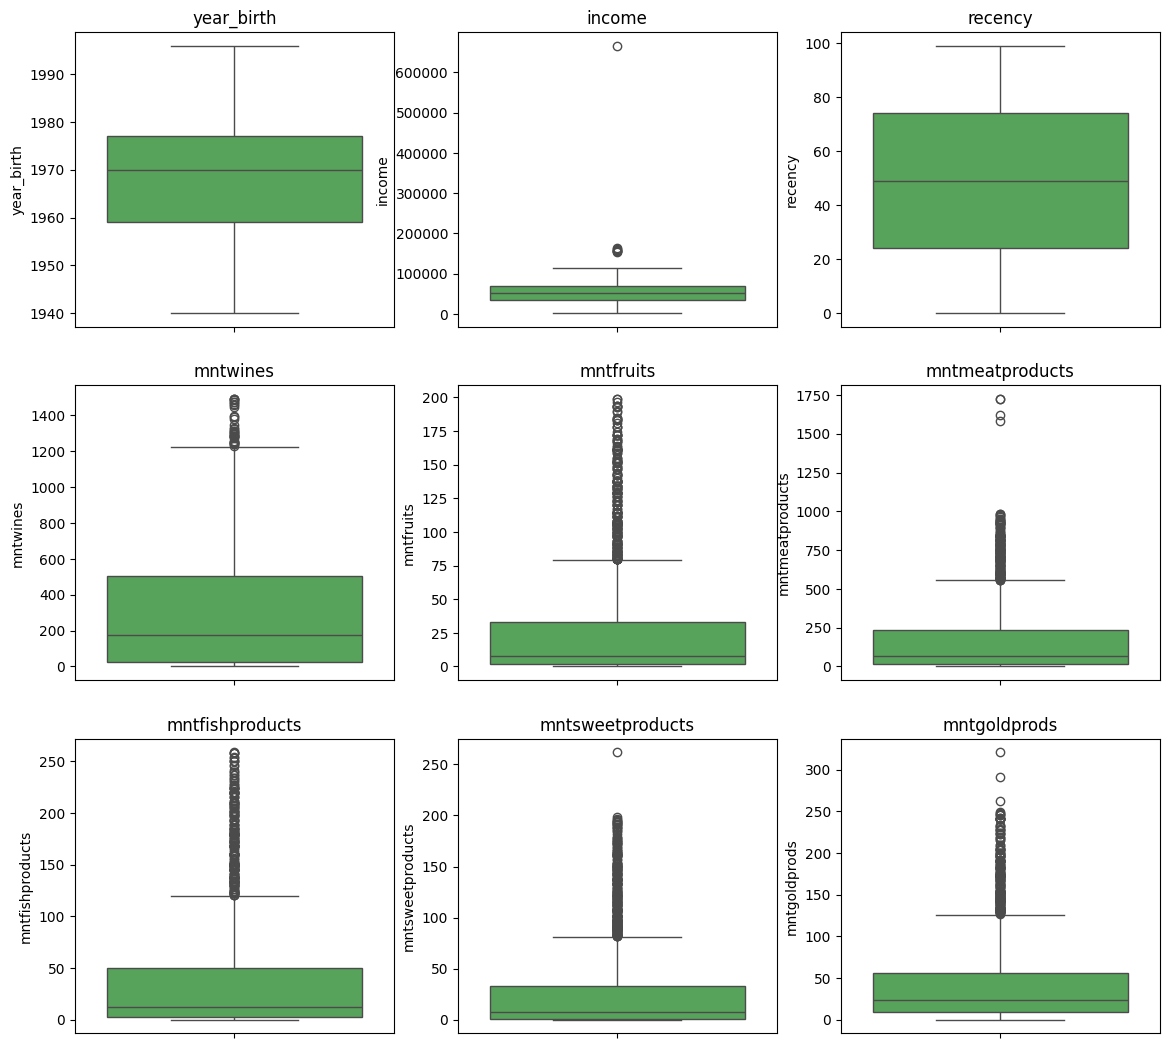

In [31]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(14, 13))
cont = 0
for i in range(3):
    for j in range(3):
        sns.boxplot(df[nums[cont]], ax=ax[i][j], color='#4CAF50')
        ax[i][j].set_title(nums[cont])
        cont = cont + 1

- Clearly, we have outlier values. However, I will only remove those that are extremely abnormal.
- I will also categorize the 'income' variable so we can analyze it from another angle later.

In [32]:
df = df[df['income'] < 200000]
df = df[df['mntmeatproducts'] < 1250]
df = df[df['mntsweetproducts'] < 220]
df = df[df['mntgoldprods'] < 255]

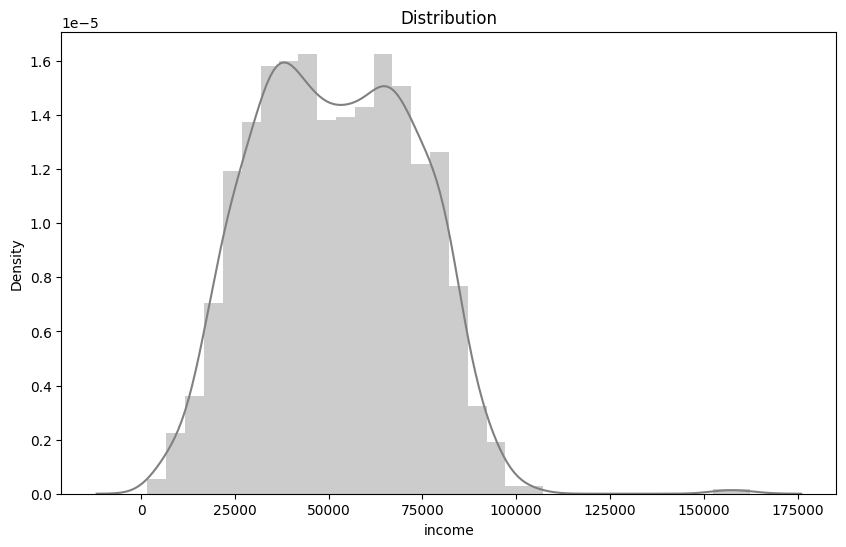

In [33]:
plt.figure(figsize=(10,6))
sns.distplot(df['income'], color='gray')
plt.title('Distribution')
plt.show()

In [34]:
df['income'].describe()

,income
count,2204.000000
mean,51870.863884
std,21070.106226
min,1730.000000
25%,35335.500000
50%,51371.000000
75%,68413.250000
max,162397.000000


The following criteria were chosen by analyzing the distribution of the data.

- 0 -> 0 - 10000
- 1 -> 10000 - 51500
- 2 -> 51500 - 100000
- 3 -> above 100000

In [35]:
def income_cat(income):
    if 0 <= income <= 10000:
        return 0
    elif 10000 < income <= 51500:
        return 1
    elif 51500 < income <= 100000:
        return 2
    else:
        return 3

df['income_cat'] = df['income'].apply(income_cat)

In [36]:
pd.set_option('display.max_columns', None)

In [37]:
df.head()

,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,response,complain,age,register_time,all_purchases,total_mnt,income_cat
0,1970,Graduation,Divorced,84835.0,0,0,2014-06-16,0,189,104,379,111,189,218,1,4,4,6,1,1,0,44,173,15,1190,2
1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,5,64,7,0,37,1,7,3,7,5,1,0,53,174,18,577,2
2,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,11,59,15,2,30,1,3,2,5,2,0,0,56,207,11,251,2
3,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,10,0,1,0,0,0,1,1,0,2,7,0,0,47,31,4,11,1
4,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,6,16,24,11,0,34,2,3,1,2,7,1,0,25,124,8,91,1


In [38]:
# Total number of children and teenagers at home
df['kids_teens'] = df['kidhome'] + df['teenhome']

In [39]:
# education + marital_status
df['status'] = df['education'] + '_' + df['marital_status']

In [40]:
df['status'].nunique()

31

In [41]:
df.drop(['dt_customer', 'year_birth'], axis=1, inplace=True)

In [42]:
nulls(df)

,cols,values_missing,rate


## Answering some business questions

In [43]:
colors = sns.color_palette('YlOrBr')

### Proportion of Customers Who Accepted/Did Not Accept the Marketing Campaign

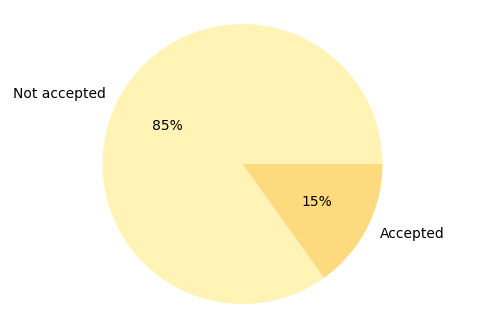

In [44]:
fig, ax = plt.subplots(figsize=(6,4))

ax.pie(df['response'].value_counts(), labels=['Not accepted', 'Accepted'],
       colors=colors, autopct='%.0f%%')

ax.axis('equal')
plt.show()

### Relationship Between Customer Characteristics and Their Acceptance of the Marketing Campaign

In [45]:
df.head()

,education,marital_status,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,response,complain,age,register_time,all_purchases,total_mnt,income_cat,kids_teens,status
0,Graduation,Divorced,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0,44,173,15,1190,2,0,Graduation_Divorced
1,Graduation,Single,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,1,0,53,174,18,577,2,0,Graduation_Single
2,Graduation,Married,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,56,207,11,251,2,1,Graduation_Married
3,Graduation,Together,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,47,31,4,11,1,2,Graduation_Together
4,Graduation,Single,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,25,124,8,91,1,1,Graduation_Single


In [46]:
# Categorics
cats = ['education', 'marital_status', 'kidhome', 'teenhome', 'complain', 'income_cat', 'kids_teens', 'status']

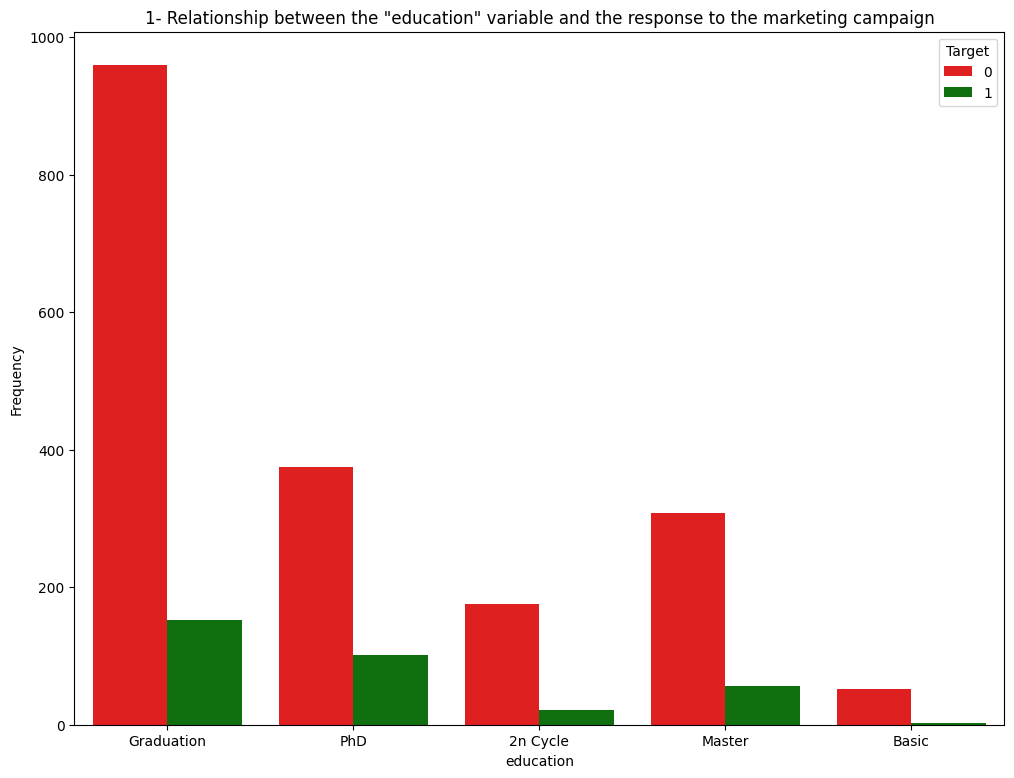

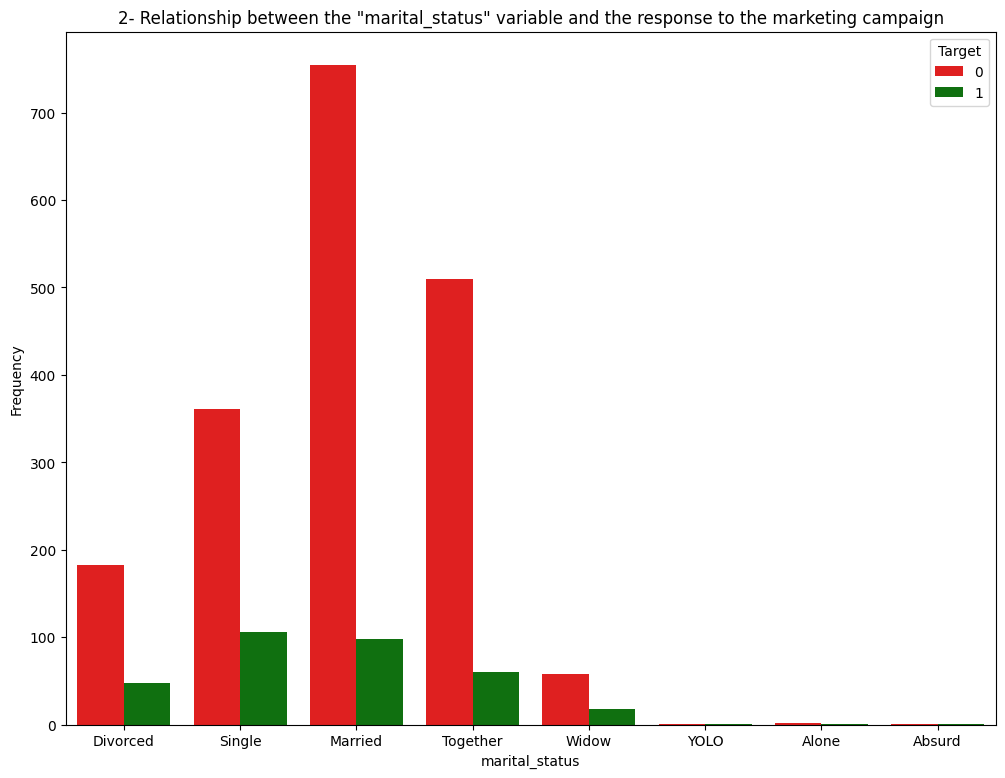

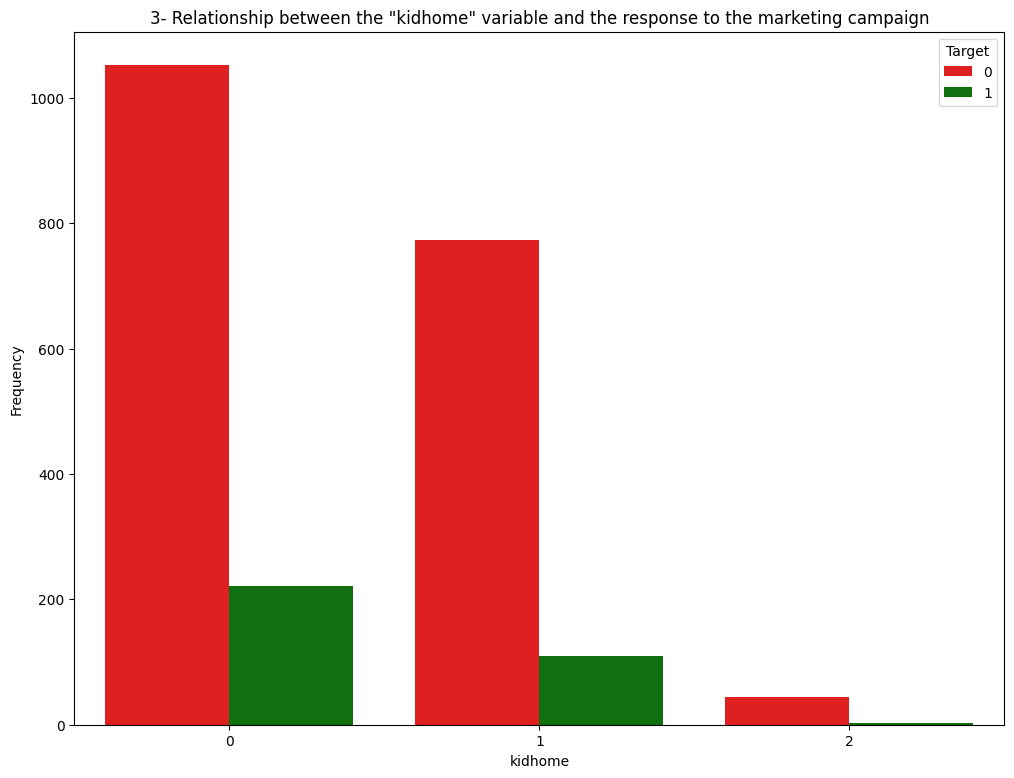

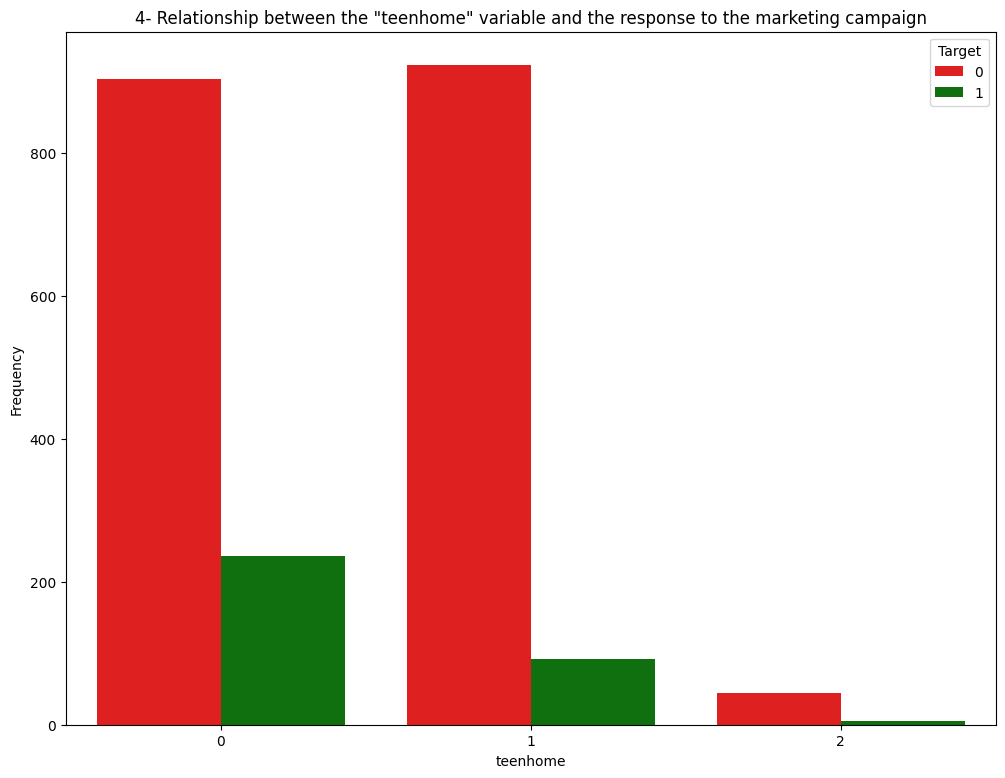

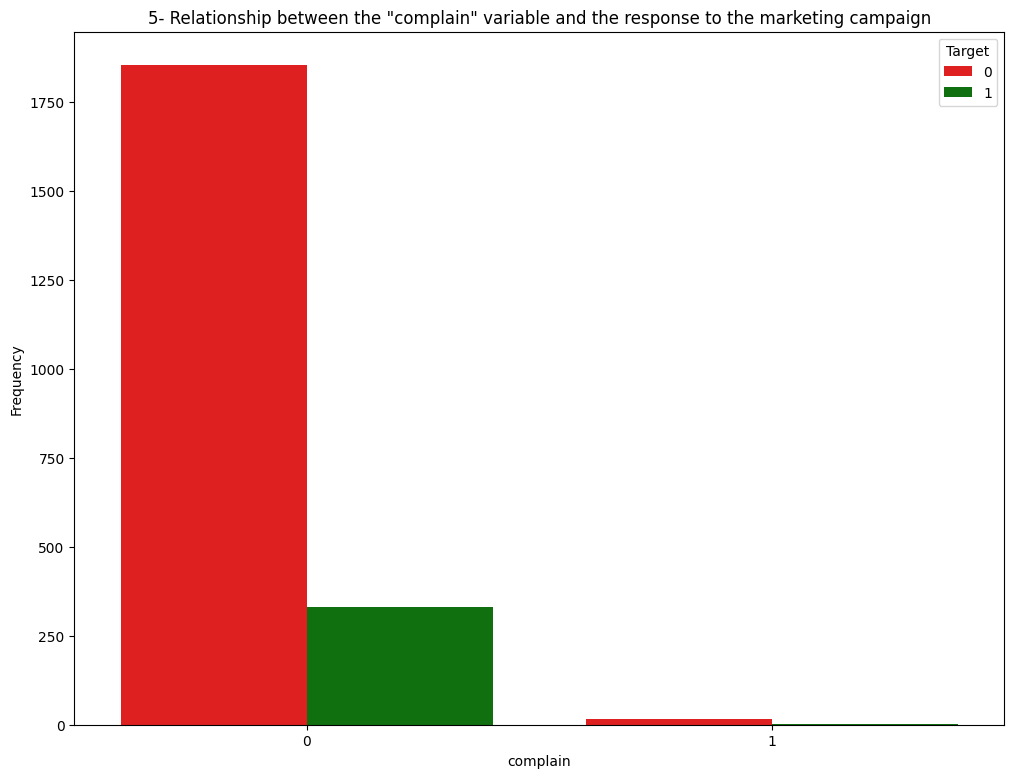

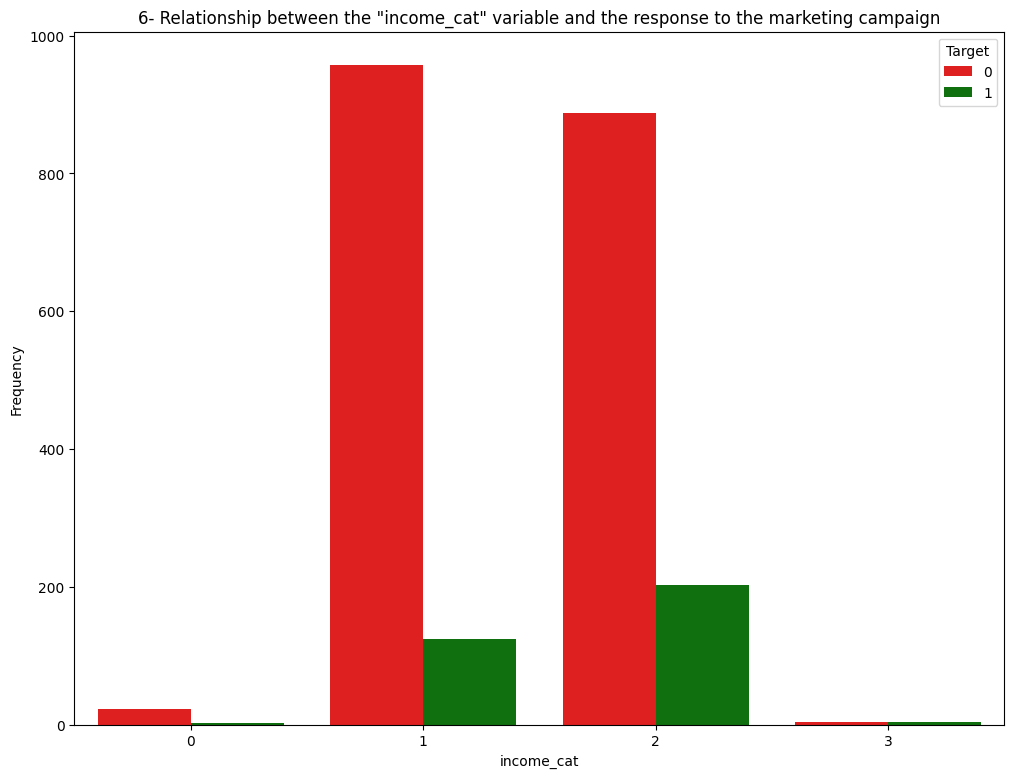

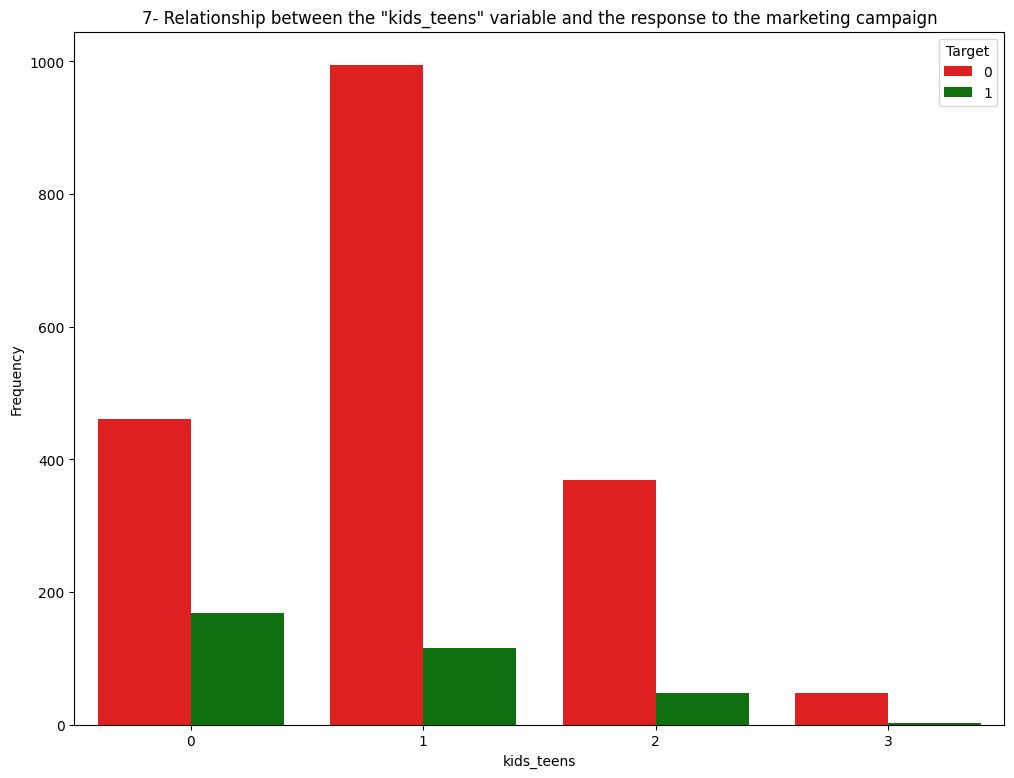

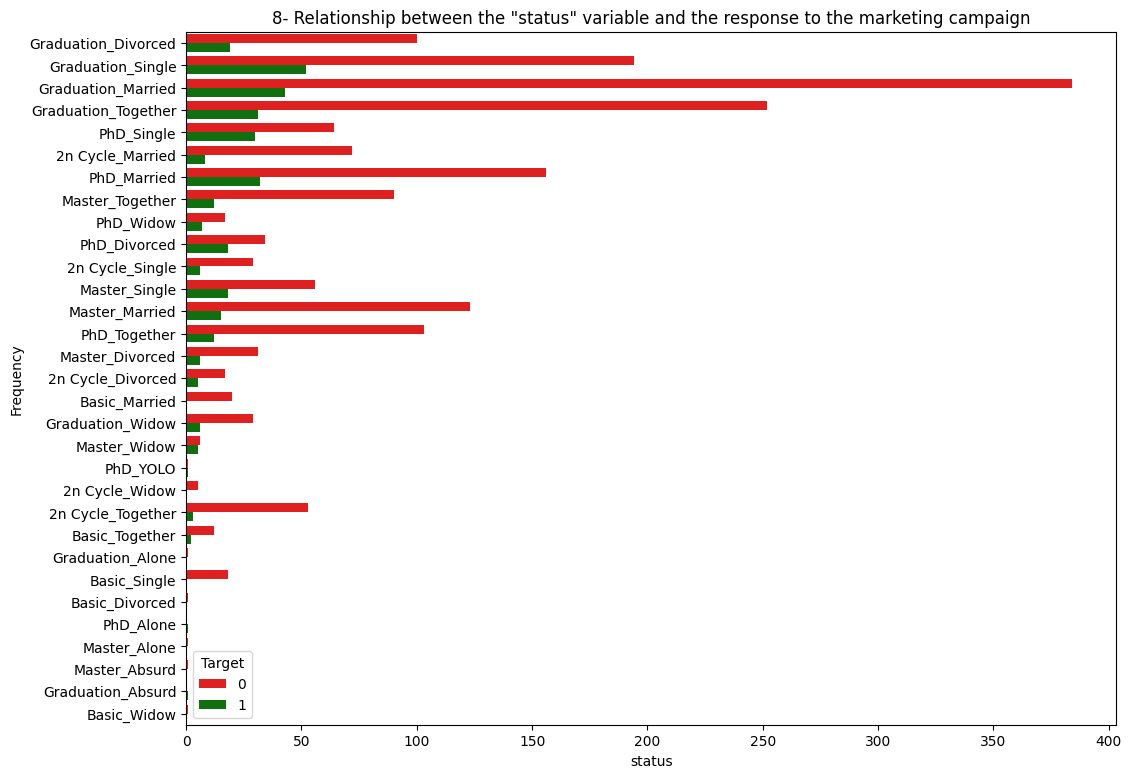

In [47]:
cnt = 0
for col in cats:
  cnt += 1
  plt.figure(figsize=(12, 9))
  if df[col].nunique() > 10:
    sns.countplot(y=col, hue='response', data=df, palette=["red", "green"])
  else:
    sns.countplot(x=col, hue='response', data=df, palette=["red", "green"])

  plt.title(f'{cnt}- Relationship between the "{col}" variable and the response to the marketing campaign')
  plt.xlabel(f'{col}')
  plt.ylabel('Frequency')
  plt.legend(title='Target')
  plt.show()

- Chart 1
  - Proportionally, 'PhD' has the highest acceptance rate.
  - Customers with undergraduate and graduate degrees are more likely to respond positively to the marketing campaign.

- Chart 2
  - Single and divorced individuals clearly have better acceptance rates.
  - Married and cohabiting individuals should still be considered despite having a lower acceptance rate.

- Chart 3
  - Having children or not at home seems to have no significant influence.
  - Few have two children.

- Chart 4
  - Those without teenagers accepted more.

- Chart 5
  - There were very few complaints.

- Chart 6
  - Customers in higher income categories are more likely to respond positively.

- Chart 7
  - Not having children or teenagers reflects a higher acceptance rate.

- Chart 8
  - Single graduates show the highest acceptance rates.
  - Single PhD and Divorced PhD have the highest acceptance rates.
  - Married graduates showed a high rejection rate.
  - A mention is warranted for widowed Masters and PhDs. They show good results, but the sample size is small.

### Relationship Between Income and Total Spending

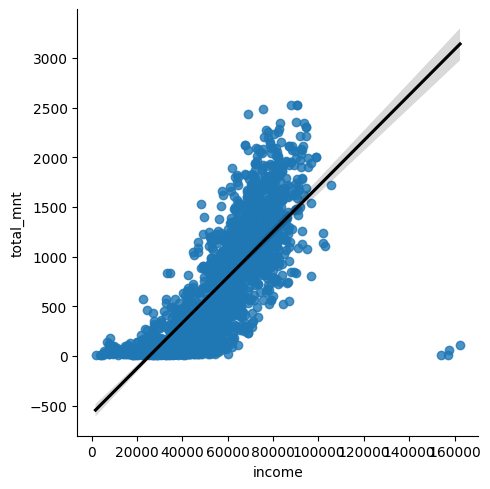

In [48]:
sns.lmplot(x = 'income', y = 'total_mnt', data = df, line_kws = {'color': 'black'})

Total spending has a positive correlation with income

 ### Age Distribution of Those Who Accepted and Did Not Accept the Campaign.

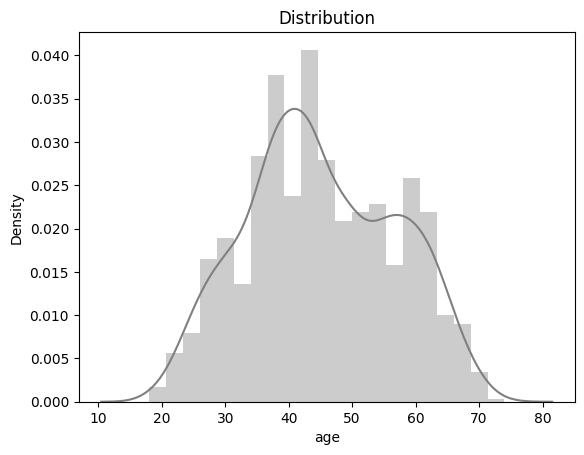

In [49]:
sns.distplot(df['age'], color='gray')
plt.title('Distribution')
plt.show()

In [50]:
age_acc = df[df['response'] == 1]
age_not = df[df['response'] == 0]

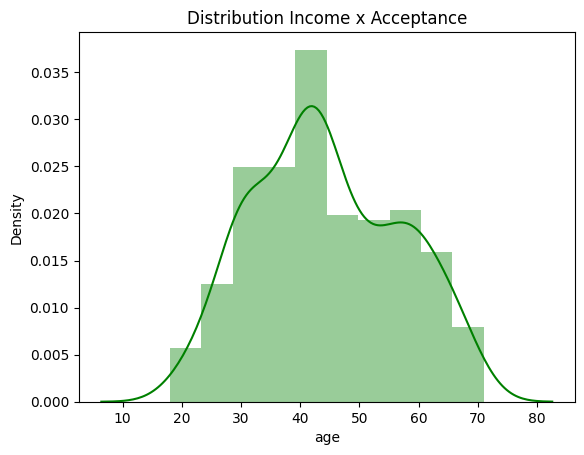

In [51]:
sns.distplot(age_acc['age'], color='green')
plt.title('Distribution Income x Acceptance')
plt.show()

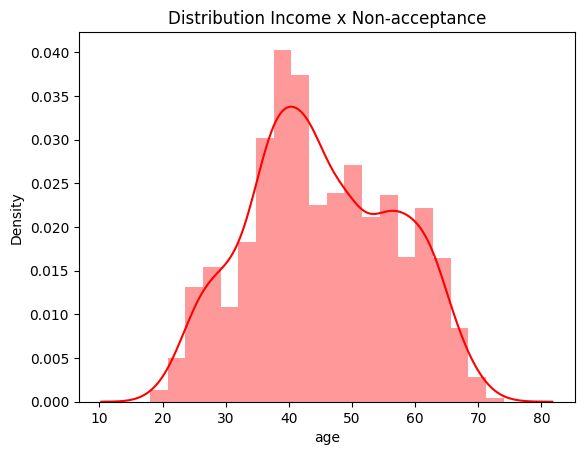

In [52]:
sns.distplot(age_not['age'], color='red')
plt.title('Distribution Income x Non-acceptance')
plt.show()

- Our highest number of acceptances and rejections are in the 40s age range.

### Correlation of Quantitative Variables

In [53]:
quants = [x for x in df.columns if x not in cats]
quants.remove('response')

In [54]:
df_quant = df[quants]

In [55]:
scaler = StandardScaler()
df_quant = scaler.fit_transform(df_quant)

In [56]:
df_quant = pd.DataFrame(df_quant, columns=quants)
df_quant['response'] = df['response']

In [57]:
corr = df_quant.corr()

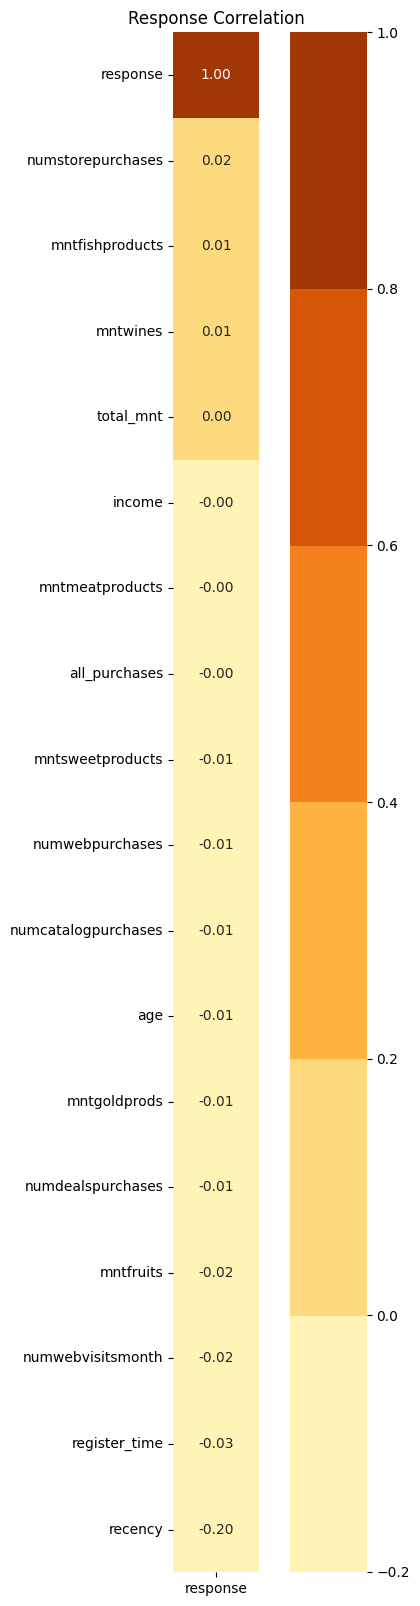

In [58]:
plt.figure(figsize=(8, 20))
sns.heatmap(pd.DataFrame(corr['response'].sort_values(ascending=False)),
            annot=True,
            cmap=colors,
            cbar=True,
            square=True,
            fmt='.2f')
plt.title('Response Correlation')
plt.show()

Interestingly, only 'Recency' showed a significant direct correlation with responses to the campaigns.

### Relationship Between Total Spending and Response to Marketing Campaigns

<Axes: xlabel='response', ylabel='total_mnt'>

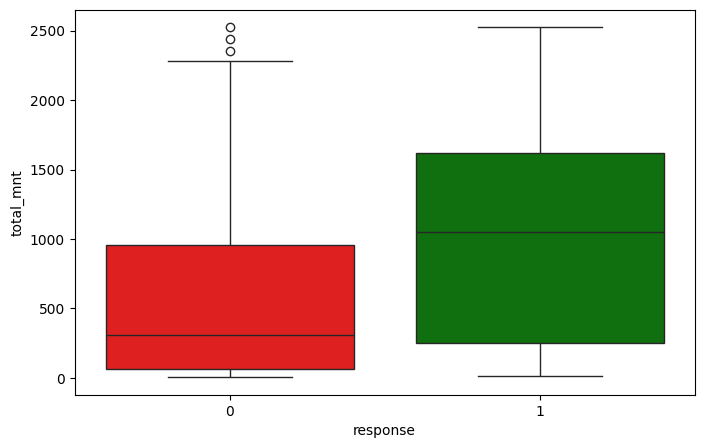

In [59]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='response', y='total_mnt', data=df, palette=['red', 'green'])

### Relationship Between Income and Response to Marketing Campaigns

<Axes: xlabel='response', ylabel='income'>

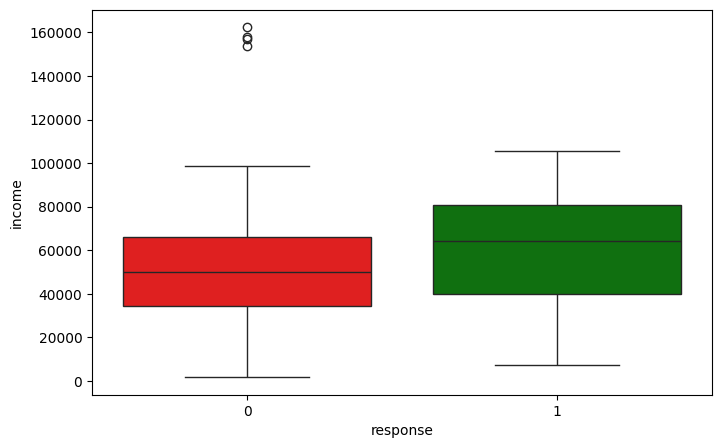

In [60]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='response', y='income', data=df, palette=['red', 'green'])

Those who spend more and have higher incomes respond positively to campaigns.

### Product Category in Which Customers Spend the Most

In [61]:
df.head()

,education,marital_status,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,response,complain,age,register_time,all_purchases,total_mnt,income_cat,kids_teens,status
0,Graduation,Divorced,84835.0,0,0,0,189,104,379,111,189,218,1,4,4,6,1,1,0,44,173,15,1190,2,0,Graduation_Divorced
1,Graduation,Single,57091.0,0,0,0,464,5,64,7,0,37,1,7,3,7,5,1,0,53,174,18,577,2,0,Graduation_Single
2,Graduation,Married,67267.0,0,1,0,134,11,59,15,2,30,1,3,2,5,2,0,0,56,207,11,251,2,1,Graduation_Married
3,Graduation,Together,32474.0,1,1,0,10,0,1,0,0,0,1,1,0,2,7,0,0,47,31,4,11,1,2,Graduation_Together
4,Graduation,Single,21474.0,1,0,0,6,16,24,11,0,34,2,3,1,2,7,1,0,25,124,8,91,1,1,Graduation_Single


In [62]:
# Product columns
prods = ['mntwines', 'mntfruits', 'mntmeatproducts', 'mntfishproducts', 'mntsweetproducts', 'mntgoldprods']

In [63]:
df_prods = pd.DataFrame(df[prods].sum(), columns=['sum']).reset_index()
df_prods

,index,sum
0,mntwines,675049
1,mntfruits,58201
2,mntmeatproducts,362742
3,mntfishproducts,83246
4,mntsweetproducts,59549
5,mntgoldprods,96280


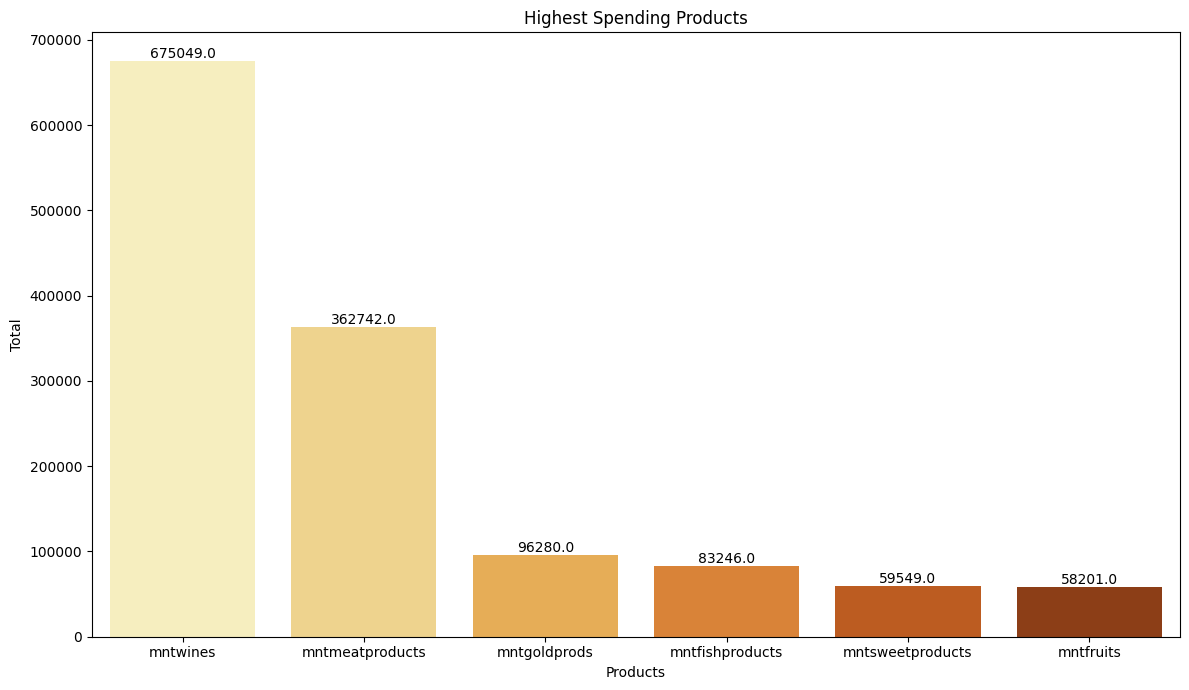

In [64]:
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='index',
                 y='sum',
                 data=df_prods.sort_values('sum', ascending=False),
                 palette=colors)

plt.xlabel('Products')
plt.ylabel('Total')
plt.title('Highest Spending Products')

for p in ax.patches:
  ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'bottom')

# Display
plt.tight_layout()
plt.show()

Spending on wine and meat is significantly higher than on other products.

### Relationship Between Spending on Wine/Meat and Response to Marketing Campaigns

<Axes: xlabel='response', ylabel='mntwines'>

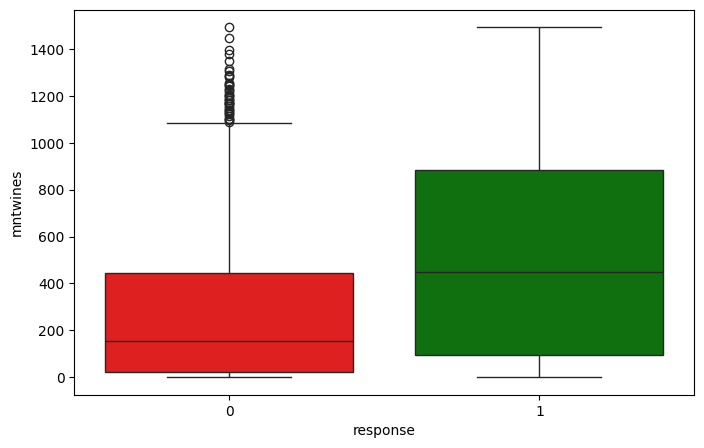

In [65]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='response', y='mntwines', data=df, palette=['red', 'green'])

<Axes: xlabel='response', ylabel='mntmeatproducts'>

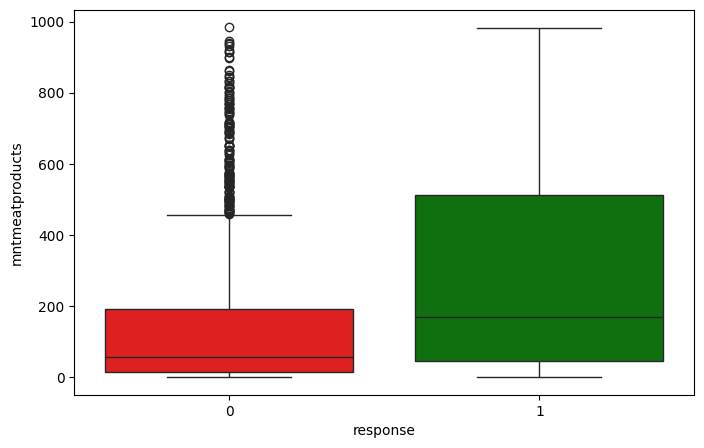

In [66]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='response', y='mntmeatproducts', data=df, palette=['red', 'green'])

The more a customer spends on meat and wine, the higher the conversion rate.

### Highest Number of Sales by Purchase Types

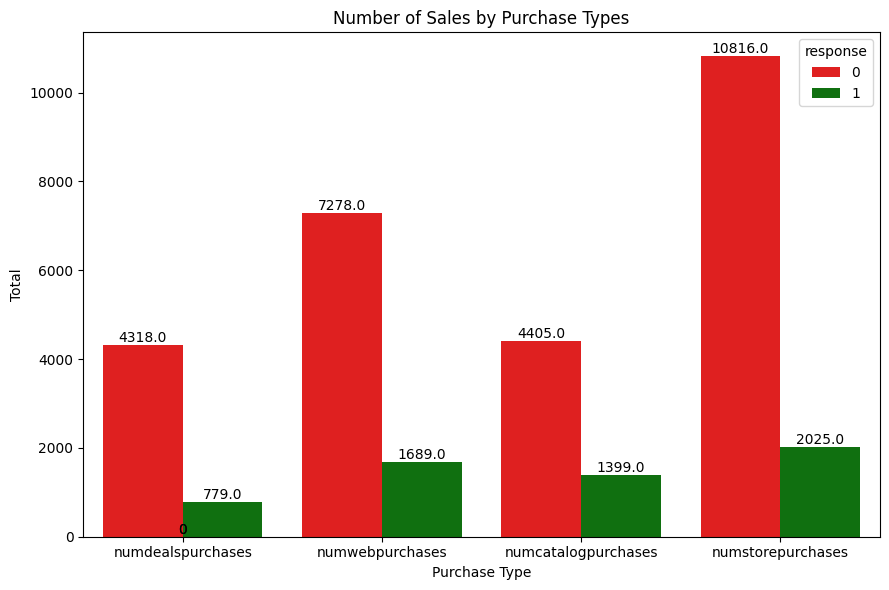

In [67]:
purch = ['numdealspurchases',
         'numwebpurchases',
         'numcatalogpurchases',
         'numstorepurchases']

df_purch = df.groupby('response')[purch].sum().reset_index()

df_purch_long = df_purch.melt(id_vars='response',
                               value_vars=purch,
                               var_name='Purchase Type',
                               value_name='Total')

plt.figure(figsize=(9, 6))
ax = sns.barplot(x='Purchase Type',
                 y='Total',
                 hue='response',
                 data=df_purch_long,
                 palette=['red', 'green'])

plt.xlabel('Purchase Type')
plt.ylabel('Total')
plt.title('Number of Sales by Purchase Types')

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.show()

The type of purchase does not have significant differences among themselves. However, the acceptance rate for catalog purchases is better.

# Statistical Modeling

## Pre-Processing

In [68]:
X = df.drop(['response', 'kids_teens', 'status', 'income_cat', 'complain'], axis=1)

In [69]:
y = df['response']

In [70]:
X.shape

(2204, 21)

In [71]:
from sklearn.preprocessing import LabelEncoder

In [72]:
X = pd.get_dummies(X, columns=['education', 'marital_status'])

In [73]:
X.shape

(2204, 32)

In [74]:
x_cols = X.columns

In [75]:
X = scaler.fit_transform(X)

In [76]:
X = pd.DataFrame(X, columns=x_cols)

Since the 'response' is unbalanced, I decided to model by setting the weights.

In [77]:
classes = np.unique(y)

In [78]:
class_w = compute_class_weight(class_weight='balanced', classes=classes, y=y)
weights = {key: value for key, value in zip(classes, class_w)}
weights

{0: 0.5889898450026724, 1: 3.309309309309309}

### Multicollinearity

To treat multicollinearity I used the model's feature importance in conjunction with VIF.

The idea is simple: Through an iterative process, eliminate the least important features (with high VIF) until there is no variable left with a VIF greater than 5.

The iterative process:

1. Eliminate the least important variable with high VIF
2. Recalculate Feature Importance
3. Recalculate the VIF

In [79]:
def treat_multicol(train, y, weights):

    '''
    Returns the dataframe without multicollinear variables and the names of unimportant variables in the last loop (in case you want to exclude them).
    '''
    xgb = XGBClassifier(random_state=21, objective='binary:logistic', class_weight=weights)

    cnt = 0
    # Loop to handle multicollinearity
    while True:
        cnt += 1
        xgb.fit(train, y)

        # Calculates the VIF
        df = sm.add_constant(train.select_dtypes(include=[np.number]))
        vif = pd.DataFrame()
        vif['Variable'] = df.columns
        vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

        if cnt == 1:
            display(vif.T)

        # Remove variables with VIF NaN
        nan_vif_vars = vif[vif['VIF'].isna()]['Variable'].tolist()
        for var in nan_vif_vars:
            train.drop(columns=[var], inplace=True)

        # Filter variables with VIF > 4.5
        highly_correlated_variable_vif = vif[vif['VIF'] > 4.5]['Variable'].tolist()

        # Stop condition
        if not highly_correlated_variable_vif:
            # Feature Importance
            importances = xgb.feature_importances_
            feature_names = train.columns
            importance_names = sorted(zip(importances, feature_names), reverse=True)

            plt.figure(figsize=(10, 6))
            sns.barplot(x=[importance for importance, _ in importance_names],
                        y=[name for _, name in importance_names])
            plt.title('Feature Importance')
            plt.xlabel('Importance')
            plt.ylabel('Features')
            plt.show()

            display(vif.T)

            # Select variables with very low importance
            low_importance_vars = [name for importance, name in importance_names if importance < 0.01]
            print('*-' * 30)
            print(f'\nVariables with very low importance: {low_importance_vars}')
            break

        # Importance of variables
        importances = xgb.feature_importances_
        feature_names = train.columns
        importance_names = sorted(zip(importances, feature_names), reverse=False)

        # Least important variable among those highly correlated
        least_important_highly_correlated = next((name for importance, name in importance_names if name in highly_correlated_variable_vif), None)

        print(f'\nDeleted variable: {least_important_highly_correlated}')
        print('*-' * 30)

        # Removes the least important variable with high VIF
        if least_important_highly_correlated:
            train.drop(columns=[least_important_highly_correlated], inplace=True)

    # Returns the treated DataFrame
    return train, low_importance_vars

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
Variable,const,income,kidhome,teenhome,recency,mntwines,mntfruits,mntmeatproducts,mntfishproducts,mntsweetproducts,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,age,register_time,all_purchases,total_mnt,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,marital_status_Absurd,marital_status_Alone,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Together,marital_status_Widow,marital_status_YOLO
VIF,1.0,4.918179,1.928977,1.706921,1.011705,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,3.172713,1.319498,1.257409,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf



Deleted variable: marital_status_Absurd
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Deleted variable: education_2n Cycle
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Deleted variable: all_purchases
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Deleted variable: mntfruits
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Deleted variable: marital_status_Widow
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Deleted variable: mntsweetproducts
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Deleted variable: mntfishproducts
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Deleted variable: mntwines
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Deleted variable: mntmeatproducts
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Deleted variable: marital_status_Together
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Deleted variable: income
*-*-*-

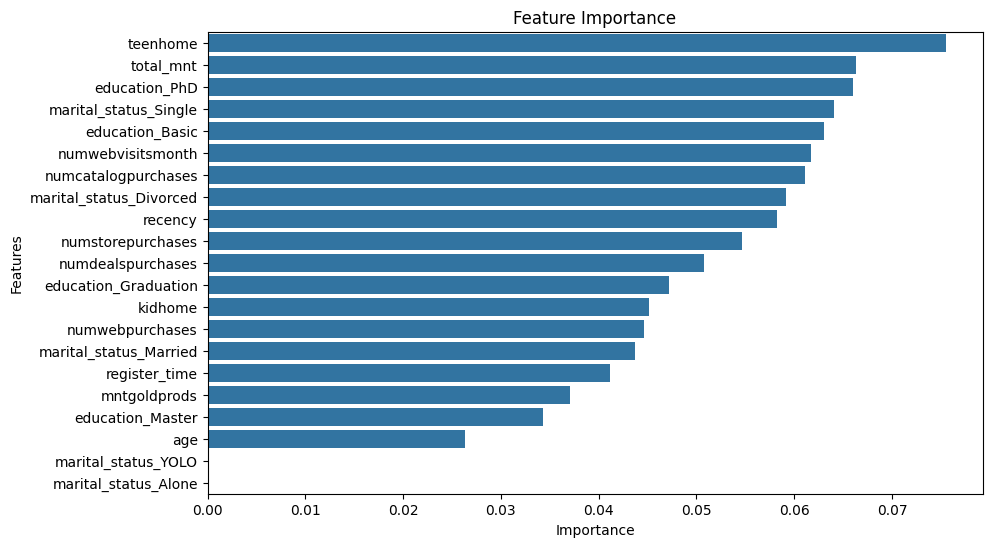

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
Variable,const,kidhome,teenhome,recency,mntgoldprods,numdealspurchases,numwebpurchases,numcatalogpurchases,numstorepurchases,numwebvisitsmonth,age,register_time,total_mnt,education_Basic,education_Graduation,education_Master,education_PhD,marital_status_Alone,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_YOLO
VIF,1.0,1.901112,1.52596,1.008797,1.567602,1.722211,2.192714,3.213828,2.415991,2.352661,1.294398,1.251087,4.432317,1.282838,3.329537,2.44169,2.830381,1.010471,1.21835,1.437877,1.396033,1.015024


*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Variables with very low importance: ['marital_status_YOLO', 'marital_status_Alone']


In [80]:
X, low_imp = treat_multicol(X, y, weights)

The multicollinearity problem was resolved. However, we can see in the graph that there are still variables without importance, so I will work on Feature Selection.

## ExtraTree - Feature Selection

In [81]:
X.shape

(2204, 21)

In [82]:
X.drop(low_imp, axis=1, inplace=True)

The function below performs iterative Feature Selection based on the importance of each variable.

1. Trains the model with Grid Search.
2. Extracts the variable importances and plots them so we can monitor the process.
3. Identifies unimportant variables and excludes them.

The process repeats until only variables with some degree of importance remain.

In [83]:
from sklearn.ensemble import ExtraTreesClassifier

# Iterative feature selection
def iterative_FE(X, y, threshold=0.02, weights=None, param=False):
    '''
    threshold: threshold of importance
    weights: class_weight
    param: Whether or not to show the parameters chosen in the last model

    Returns the dataframe with the most important variables and the last best model
    '''

    while True:

        ext = ExtraTreesClassifier(random_state=21)

        ext_params = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [2, 4],
            'class_weight': [weights] if weights is not None else [None]
        }

        kfold = StratifiedKFold(n_splits=10)

        # GridSearchCV
        extcv = GridSearchCV(ext, param_grid=ext_params, cv=kfold, scoring='roc_auc', verbose=1)
        extcv.fit(X, y)

        ext_best = extcv.best_estimator_

        # Feature Importance
        importances = ext_best.feature_importances_
        feature_names = X.columns
        importance_names = sorted(zip(importances, feature_names), reverse=True)

        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x=[importance for importance, _ in importance_names],
                    y=[name for _, name in importance_names])
        plt.title('Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.show()

        # Identifying variables with low importance
        low_imp = [name for importance, name in importance_names if importance < threshold]

        # If there are no more variables with low importance, exit the loop
        if not low_imp:
            print('*-' * 30)
            print('\nNo variables with importance below the threshold.\n')
            print('*-' * 30)

            if param:
                print('\nParameters:\n')
                print(f'{extcv.best_params_}\n')
                print('*-' * 30)

            print(f'\nModel Score: {extcv.best_score_}\n')
            break

        # Excluding variables with low importance
        print('*-' * 30)
        print(f'\nDeleted variables: {low_imp}\n')
        print('*-' * 30)
        X.drop(low_imp, axis=1, inplace=True)

    return X, ext_best

Fitting 10 folds for each of 36 candidates, totalling 360 fits


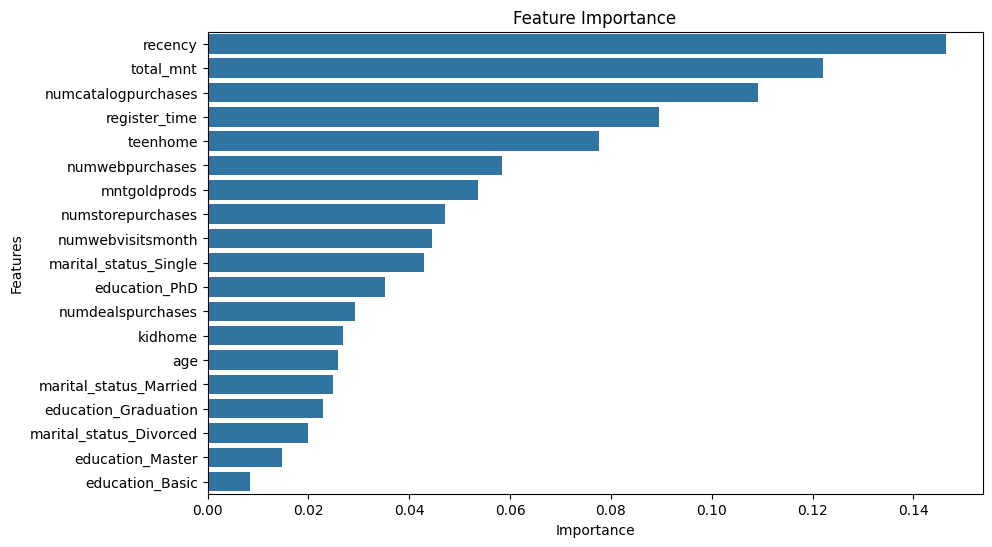

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Deleted variables: ['marital_status_Divorced', 'education_Master', 'education_Basic']

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Fitting 10 folds for each of 36 candidates, totalling 360 fits


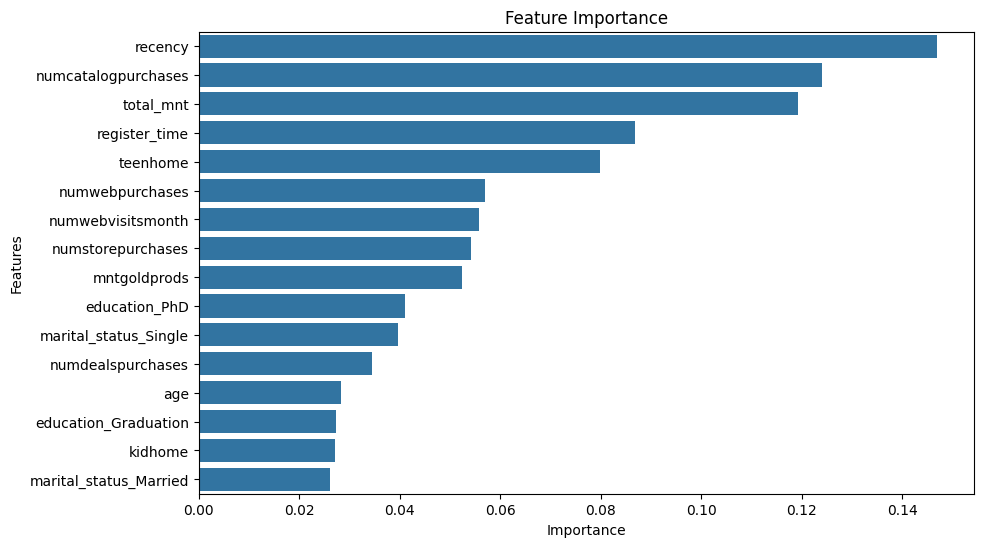

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

No variables with importance below the threshold.

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Parameters:

{'class_weight': {0: 0.5889898450026724, 1: 3.309309309309309}, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Model Score: 0.8177981653050758



In [84]:
X, ext_best = iterative_FE(X, y, weights=weights, param=True)

## Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression

In [86]:
lgr = LogisticRegression(random_state=21)

In [87]:
lgr_params = {
          'penalty': ['l1', 'l2', 'elasticnet'],
          'tol': [0.00001, 0.000001, 0.0000001],
          'C': [0.01, 0.1, 1.0, 2.0, 3.0],
          'solver': ['liblinear', 'newton'],
          'max_iter': [100, 200, 500]
      }

In [88]:
kfold = StratifiedKFold(n_splits=10)

In [89]:
lgrcv = GridSearchCV(lgr, param_grid=lgr_params, cv=kfold, scoring='roc_auc', verbose=1)

In [90]:
lgrcv.fit(X, y)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(random_state=21),
             param_grid={'C': [0.01, 0.1, 1.0, 2.0, 3.0],
                         'max_iter': [100, 200, 500],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'newton'],
                         'tol': [1e-05, 1e-06, 1e-07]},
             scoring='roc_auc', verbose=1)

In [91]:
lgr_best = lgrcv.best_estimator_

In [92]:
lgrcv.best_params_

{'C': 0.1,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'liblinear',
 'tol': 1e-05}

In [93]:
lgrcv.best_score_

0.8614582743905494

In [94]:
coefs = lgr_best.coef_[0]
coefs

array([ 0.07234852, -0.44186453, -0.70466672,  0.04011823,  0.11073862,
        0.15472479,  0.40275792, -0.57394633,  0.23757036,  0.        ,
        0.40477506,  0.70249242,  0.        ,  0.25069556, -0.13740276,
        0.22315695])

In [95]:
odds = np.exp(coefs)
odds

array([1.07502995, 0.64283672, 0.49427328, 1.04093384, 1.11710288,
       1.16733665, 1.49594471, 0.56329809, 1.26816422, 1.        ,
       1.49896528, 2.0187781 , 1.        , 1.28491884, 0.8716191 ,
       1.25001674])

In [96]:
coefficients = pd.DataFrame({'Variable': X.columns,
                             'Coefficient': coefs,
                             'Odds_Ratios': odds})

In [97]:
coefficients.sort_values(by='Odds_Ratios', ascending=False)

,Variable,Coefficient,Odds_Ratios
11,total_mnt,0.702492,2.018778
10,register_time,0.404775,1.498965
6,numcatalogpurchases,0.402758,1.495945
13,education_PhD,0.250696,1.284919
8,numwebvisitsmonth,0.237570,1.268164
15,marital_status_Single,0.223157,1.250017
5,numwebpurchases,0.154725,1.167337
4,numdealspurchases,0.110739,1.117103
0,kidhome,0.072349,1.075030
3,mntgoldprods,0.040118,1.040934


# CONCLUSION

The factors that best explain customer responses to the marketing campaign are: total spending, recency, teenagers at home, registration time, number of purchases made directly in stores, and catalog purchases.

- The more the customer spends, the higher the probability they will respond to the campaign. Note that total spending is highly correlated with income.

- The longer the customer is registered, the higher the probability they will respond, meaning long-term customers are more loyal and likely to respond to campaigns.

- The more purchases made by catalog, the higher the probability the customer will respond.

- Single customers and those with a PhD have a slightly positive reaction to campaigns.

- A higher number of visits to the company's website in the last month can be a positive factor.

- Customers who haven't purchased recently are less likely to respond to campaigns.

- The more purchases made directly in the store, the lower the probability the customer will respond, possibly due to shopping preferences.

- Having teenagers at home decreases the chances of accepting campaigns.

Ideas:

- Offer incentives to increase total customer spending or loyalty.

- Promote products and services through the catalog.

- Create marketing campaigns targeted at customers with a PhD, single customers, or those who frequently visited the site in the last month.

- Introduce products or services that attract teenagers and meet the needs of the whole family.
